# Q value of Series RLC circuit

Consider a series LC circuit inductively coupled to a resistor. 
Or actually a inductively coupled readout resonator.

The oscillation may be shifted, if the coupling region is apprent enough, 
i.e. the coupled inductance $L_f$ on dissipation line is not negliable.

The Q value should decreases with the coupling mutual inductance $M$,

We calculate them as did in another notebook "Q value of LC CCoupled". 
We compute the input impendence of the whole circuit. 
It should varies with probe frequency $\omega$.

$$
Z_\mathrm{in}=\frac{1}{i\omega C} +i\omega ( L-M) +\frac{1}{\frac{1}{i\omega M} +\frac{1}{i\omega ( L_{f} -M) +2Z_0}},
$$
where $2Z_0$ is the equivalent resistor by the outgoing transmission line.

The imagnary part $\mathrm{Im}[Z\mathrm{in}]$ vanishes when resonant,
and the derivative there is $2L^\prime$ which shows the modified inductance.
With that, we can calculate the Q value with $Q=\omega_0 L / R$

Unperturbed freq is 3.751 GHz
Q is 0.8485 million, freq shift is 0.000 MHz


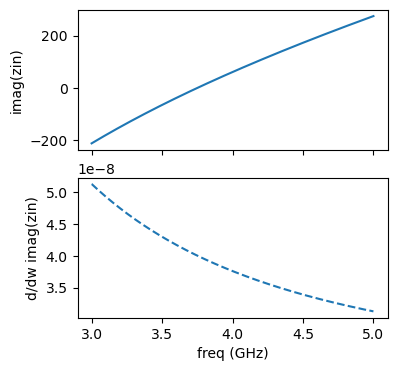

In [1]:
import numpy as np
import matplotlib.pyplot as plt

L = 20e-9
C = 90e-15
w00 = 1/np.sqrt(L * C)  # Unperturbed frequency.
print(f"Unperturbed freq is {w00/(2*np.pi)/1e9:.3f} GHz")

w = np.linspace(3e9, 5e9, 1001) * 2 * np.pi
M = 10e-12
R = 50
Lf = 0e-12
zin = 1/(1j*w*C) + 1j*w*(L-M) + 1/(1/(1j*w*M) + 1/(1j*w*(Lf-M) + 2*R))

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4,4))
ax.plot(w/2/np.pi/1e9, zin.imag)
ax2.plot(w/2/np.pi/1e9, np.gradient(zin.imag, w[1] - w[0]), '--')
ax.set_ylabel("imag(zin)")
ax2.set_ylabel("d/dw imag(zin)")
ax2.set_xlabel("freq (GHz)")

# Caution! np.interp(x, xp, yp) requires xp to be monotonic increasing.
w0 = np.interp(0, zin.imag, w)
Lp = np.interp(w0, w, np.gradient(zin.imag, w[1] - w[0])) / 2
Rp = np.interp(w0, w, zin.real)
Q = w0 * Lp / Rp
print(f"Q is {Q/1e6:.4f} million, freq shift is {(w0-w00)/1e6/2/np.pi:.3f} MHz")

with $L_f=0$, we can find $L^\prime=L, \omega_0=\omega_{00}, R^\prime=\frac{(\omega_0 M)^2}{2R}$, as checked below.

In [2]:
Lp, L, w0, w00, Rp, (w0*M)**2 / (2*R)

(2.0000004120181374e-08,
 2e-08,
 23570226792.39998,
 23570226039.551582,
 0.0005555556265287651,
 0.0005555555910451697)

Now let's figure out how does Q and frequency shift changes with $M$.

Before preceeding, let's wrap all these into `labcodes.Calculator` for more convenient manipulation.

Unperturbed freq is 3.751 GHz
Q is 0.8485 million, freq shift is 0.000 MHz


(<Figure size 400x400 with 2 Axes>,
 <AxesSubplot: ylabel='imag(zin)'>,
 <AxesSubplot: xlabel='freq (GHz)', ylabel='d/dw imag(zin)'>)

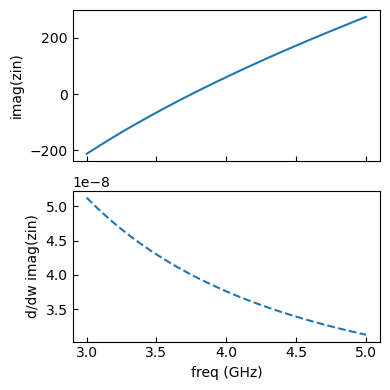

In [3]:
from labcodes.calc import Calculator, dept

class LC_MCoupled(Calculator):
    L = 20e-9
    C = 90e-15
    # Must be array with evenly spaced points.
    w = np.linspace(3e9, 5e9, 1001) * 2 * np.pi
    M = 10e-12
    R = 50
    Lf = 0e-12

    @dept
    def w00(self, L, C):
        return 1 / np.sqrt(L * C)

    @dept
    def zin(self, L, C, w, M, R, Lf):
        return (
            1 / (1j * w * C)
            + 1j * w * (L - M)
            + 1 / (1 / (1j * w * M) + 1 / (1j * w * (Lf - M) + 2 * R))
        )

    @dept
    def w0(self, zin, w):
        return np.interp(0, zin.imag, w)

    @dept
    def Lp(self, w0, w, zin):
        return np.interp(w0, w, np.gradient(zin.imag, w[1] - w[0])) / 2

    @dept
    def Rp(self, w0, w, zin):
        return np.interp(w0, w, zin.real)

    @dept
    def Q(self, w0, Lp, Rp):
        return w0 * Lp / Rp

    @dept
    def freq_shift(self, w0, w00):
        return (w0 - w00) / 2 / np.pi

    def demo(self):
        freq_GHz = self.w / 2 / np.pi / 1e9
        zin = self.zin()

        fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4, 4))
        ax.plot(freq_GHz, zin.imag)
        ax2.plot(freq_GHz, np.gradient(zin.imag, self.w[1] - self.w[0]), "--")
        ax.set_ylabel("imag(zin)")
        ax2.set_ylabel("d/dw imag(zin)")
        ax2.set_xlabel("freq (GHz)")
        return fig, ax, ax2

    def describe(self):
        w00 = self["w00"]
        w0 = self["w0"]
        Q = self["Q"]
        print(f"Unperturbed freq is {w00/(2*np.pi)/1e9:.3f} GHz")
        print(f"Q is {Q/1e6:.4f} million, freq shift is {(w0-w00)/1e6/2/np.pi:.3f} MHz")

lc = LC_MCoupled()
lc.describe()
lc.demo()

Now let's see how thing changes with $M$.

And everything just matches with the analytic results very well.

Text(0.5, 0, 'M (pH)')

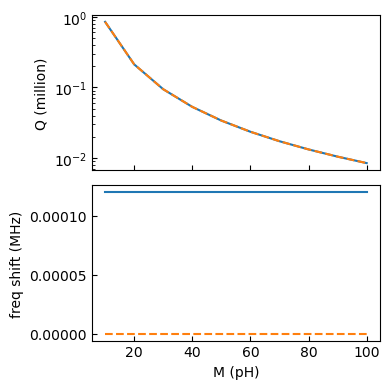

In [4]:
m_list = np.linspace(10e-12, 100e-12, 10)
lc_list = [LC_MCoupled(M=m) for m in m_list]
Q_list = np.array([lc["Q"] for lc in lc_list])
R_analytic = (lc["w00"] * m_list) ** 2 / (2 * lc["R"])
Q_analytic = lc["w00"] * lc["L"] / R_analytic
freq_shift_list = np.array([lc["freq_shift"] for lc in lc_list])

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4,4))
ax.plot(m_list/1e-12, Q_list/1e6)
ax.plot(m_list/1e-12, Q_analytic/1e6, '--')
ax2.plot(m_list/1e-12, freq_shift_list/1e6)
ax2.plot(m_list/1e-12, np.zeros_like(m_list), '--')
ax.set_ylabel("Q (million)")
ax.set_yscale("log")
ax2.set_ylabel("freq shift (MHz)")
ax2.set_xlabel("M (pH)")

But things changes if we tune Lf=1nH, for example. 

We see frequency changes, even Q value changes a bit.

Text(0.5, 0, 'M (pH)')

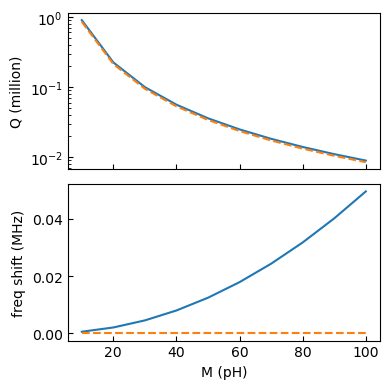

In [5]:
m_list = np.linspace(10e-12, 100e-12, 10)
lc_list = [LC_MCoupled(M=m, Lf=1e-9) for m in m_list]
Q_list = np.array([lc["Q"] for lc in lc_list])
R_analytic = (lc["w00"] * m_list) ** 2 / (2 * lc["R"])
Q_analytic = lc["w00"] * lc["L"] / R_analytic
freq_shift_list = np.array([lc["freq_shift"] for lc in lc_list])

fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(4,4))
ax.plot(m_list/1e-12, Q_list/1e6)
ax.plot(m_list/1e-12, Q_analytic/1e6, '--')
ax2.plot(m_list/1e-12, freq_shift_list/1e6)
ax2.plot(m_list/1e-12, np.zeros_like(m_list), '--')
ax.set_ylabel("Q (million)")
ax.set_yscale("log")
ax2.set_ylabel("freq shift (MHz)")
ax2.set_xlabel("M (pH)")